# Training a Raspberry Pi to Detect Traffic Signs and People in Real Time

This is tutorial is based on Chengwei's excellent Tutorial and Colab Notebook on ["How to train an object detection model easy for free"](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/).   My twist on his tutorial is that I need to run my model on a Raspberry Pi with live video feed.  As the Raspberry Pi is fairly limited on CPU power and can only run object detection at 1-2 FPS (frames/sec), I have purchased the newly release $75 Google's [EdgeTPU USB Accelarator](https://coral.withgoogle.com/products/accelerator), which can detect objects at 12 FPS, which is sufficient for real time work.  After doing the transfer learning from one of the object detection models using our own images, last few steps of the colab deals with how to convert a trained model to a model file that can be consumed by an Edge TPU, namely, the final `mymodel_quantized_edgetpu.tflite` file.  


![](https://cdn-images-1.medium.com/max/1000/1*_jABdMfUVcyPdi5b3zlfVg.jpeg)



# Section 1: Mount Google drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:

from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/model'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
ls: cannot access '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/model/..': No such file or directory


# Section 2: Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [3]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/maximecharriere/AutonomousRcCar'

# Number of training steps.
num_steps = 100  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Section 3: Set up Training Environment

## Clone the `DeepPiCar` repository or your fork.

In [4]:
import os

%cd /content

repo_dir_path = '/content/DeepPiCar' #os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
Cloning into 'AutonomousRcCar'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1091 (delta 20), reused 33 (delta 14), pack-reused 1047
Receiving objects: 100% (1091/1091), 572.78 MiB | 38.30 MiB/s, done.
Resolving deltas: 100% (404/404), done.
Checking out files: 100% (557/557), done.
[Errno 2] No such file or directory: '/content/DeepPiCar'
/content
Pull it so that we have the latest code/data
fatal: not a git repository (or any of the parent directories): .git


## Install required packages

In [5]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install -q tf_slim

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.

```

In [6]:
%cd /content/AutonomousRcCar/autonomouscar/tf_model_training

#Partition data between test and train set
!python3 scripts/partition_dataset.py -i training/images/all -o training/images -r 0.2 -x -s 43

/content/AutonomousRcCar/autonomouscar/tf_model_training


In [7]:
%cd /content/AutonomousRcCar/autonomouscar/tf_model_training

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python scripts/xml_to_csv.py -i training/images/train -o training/annotations/train_labels.csv -l training/annotations

# Convert test folder annotation xml files to a single csv.
!python scripts/xml_to_csv.py -i training/images/test -o training/annotations/test_labels.csv

# Generate `train.record`
!python scripts/generate_tfrecord.py --csv_input=training/annotations/train_labels.csv --output_path=training/annotations/train.record --img_path=training/images/train --label_map training/annotations/label_map.pbtxt

# Generate `test.record`
!python scripts/generate_tfrecord.py --csv_input=training/annotations/test_labels.csv --output_path=training/annotations/test.record --img_path=training/images/test --label_map training/annotations/label_map.pbtxt

/content/AutonomousRcCar/autonomouscar/tf_model_training
Successfully converted xml to csv.
Generate `training/annotations/label_map.pbtxt`
Successfully converted xml to csv.
Successfully created the TFRecords: /content/AutonomousRcCar/autonomouscar/tf_model_training/training/annotations/train.record
Successfully created the TFRecords: /content/AutonomousRcCar/autonomouscar/tf_model_training/training/annotations/test.record


In [8]:
test_record_fname = '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/annotations/test.record'
train_record_fname = '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/annotations/train.record'
label_map_pbtxt_fname = '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/annotations/label_map.pbtxt'

## Download base model

In [10]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [11]:
MODEL

'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03'

In [12]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 63 root   root 4.0K Jul  3 19:08 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [13]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Section 4: Transfer Learning Training

## Configuring a Training Pipeline

In [14]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [15]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [16]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [17]:
!cat {label_map_pbtxt_fname}

item {
    id: 1
    name: 'battery'
}

item {
    id: 2
    name: 'speed25'
}

item {
    id: 3
    name: 'speed50'
}

item {
    id: 4
    name: 'stop'
}

item {
    id: 5
    name: 'traffic light'
}

In [18]:
# look for num_classes: 6, since we have 5 different road signs and 1 person type (total of 6 types) 
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 5
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspe

## Run Tensorboard(Optional)

In [19]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-07-03 19:08:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.84.169.173, 18.232.237.110, 52.5.250.138, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.84.169.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.6MB/s    in 0.7s    

2020-07-03 19:08:29 (17.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [20]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [21]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [22]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Train the model

Now all inputs are set up, just train the model.   This process may take a few hours.   Since we are saving the model training results (model.ckpt-* files) in our google drive (a persistent storage that will survice the restart of our colab VM instance), we can safely leave and return a few hours later. 

In [23]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    with open('/content/gdrive/My Drive/Colab Notebooks/pw.txt') as file:
        data = file.readlines()
        
    gmail_user = 'david.tian@gmail.com'  
    gmail_password = data[0]


    sent_from = gmail_user  
    to = ['dctian@hotmail.com']  
    subject = msg  
    body = '%s\n\n- David' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')
    

In [24]:
!rm -rf /content/AutonomousRcCar/autonomouscar/tf_model_training/training/model
!mkdir  /content/AutonomousRcCar/autonomouscar/tf_model_training/training/model

In [25]:
# SendEmail("Colab train started")
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps} \
    2> "/content/gdrive/My Drive/Colab Notebooks/TransferLearning/training_log.txt"
# SendEmail("Colab train finished")

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.358
 Av

In [26]:
pipeline_fname

'/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_quantized_300x300_coco.config'

In [27]:
!ls -ltra '{model_dir}'

total 266732
drwxr-xr-x 5 root root     4096 Jul  3 19:08 ..
-rw-r--r-- 1 root root 30900123 Jul  3 19:09 graph.pbtxt
-rw-r--r-- 1 root root 74975648 Jul  3 19:09 model.ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root    68787 Jul  3 19:09 model.ckpt-0.index
-rw-r--r-- 1 root root 16431291 Jul  3 19:09 model.ckpt-0.meta
-rw-r--r-- 1 root root 74975648 Jul  3 19:11 model.ckpt-100.data-00000-of-00001
-rw-r--r-- 1 root root    68787 Jul  3 19:11 model.ckpt-100.index
-rw-r--r-- 1 root root      128 Jul  3 19:11 checkpoint
-rw-r--r-- 1 root root 16431291 Jul  3 19:11 model.ckpt-100.meta
drwxr-xr-x 2 root root     4096 Jul  3 19:11 eval_0
drwxr-xr-x 3 root root     4096 Jul  3 19:11 export
drwxr-xr-x 4 root root     4096 Jul  3 19:11 .
-rw-r--r-- 1 root root 59251283 Jul  3 19:11 events.out.tfevents.1593803346.8f176e953958


# Section 5: Save and Convert Model Output

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [28]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [29]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)


/content/AutonomousRcCar/autonomouscar/tf_model_training/training/model/model.ckpt-100


In [30]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
Instructions for updating:
Please use `layer.__call__` method instead.
W0703 19:11:30.463652 139986117580672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:32.427155 139986117580672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:32.466006 139986117580672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:32.598987 139986117580672 convolutional_box_predictor.py:156] depth of additional conv before box pred

In [31]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W0703 19:11:47.869237 140256497723264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:49.795407 140256497723264 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:49.823168 140256497723264 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0703 19:11:49.850788 140256497723264 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [32]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2020-07-03 19:11:59.916106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-03 19:11:59.930792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-03 19:11:59.931652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2020-07-03 19:11:59.931955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-03 19:11:59.935309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-03 19:11:59.936847: I tensorflow/stream_executor/platform/default/dso_loa

In [33]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops 


CONVERTING frozen graph to unquantized TF Lite file...
2020-07-03 19:12:07.274412: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-03 19:12:07.286976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-03 19:12:07.287542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2020-07-03 19:12:07.287793: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-03 19:12:07.289522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-03 19:12:07.291029: I tensorflow/stream_executor/platform/default/dso_l

In [34]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/AutonomousRcCar/autonomouscar/tf_model_training/training/model/fine_tuned_model
total 134476
drwxr-xr-x 5 root root     4096 Jul  3 19:11 ..
-rw-r--r-- 1 root root 18857216 Jul  3 19:11 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root    23543 Jul  3 19:11 model.ckpt.index
-rw-r--r-- 1 root root       77 Jul  3 19:11 checkpoint
-rw-r--r-- 1 root root  2204257 Jul  3 19:11 model.ckpt.meta
-rw-r--r-- 1 root root 19735025 Jul  3 19:11 frozen_inference_graph.pb
drwxr-xr-x 3 root root     4096 Jul  3 19:11 saved_model
-rw-r--r-- 1 root root     4366 Jul  3 19:11 pipeline.config
-rw-r--r-- 1 root root 19342722 Jul  3 19:11 tflite_graph.pb
-rw-r--r-- 1 root root 53992364 Jul  3 19:11 tflite_graph.pbtxt
-rw-r--r-- 1 root root  4777024 Jul  3 19:12 road_signs_quantized.tflite
-rw-r--r-- 1 root root 18727104 Jul  3 19:12 road_signs_float.tflite
drwxr-xr-x 3 root root     4096 Jul  3 19:12 .


## Run inference test
Test with images in repository `object_detection/data/images/test` directory.

In [35]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/AutonomousRcCar/autonomouscar/tf_model_training/training/model/fine_tuned_model/frozen_inference_graph.pb
['/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG31.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG3.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG44.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG40.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG32.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG16.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG19.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG38.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG12.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training

In [36]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



/content/models/research/object_detection


Running inferences on ['/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG31.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG3.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG44.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG40.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG32.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG16.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG19.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG38.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG12.jpg', '/content/AutonomousRcCar/autonomouscar/tf_model_training/training/images/test/IMG23.jpg']


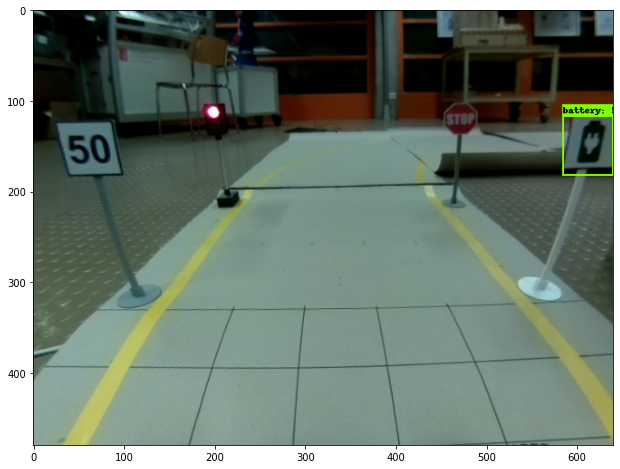

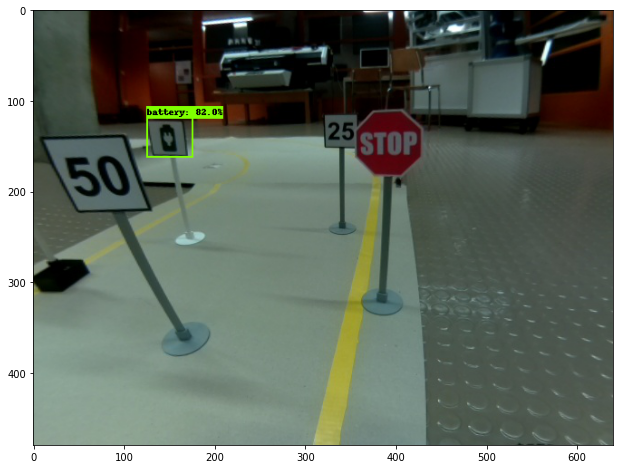

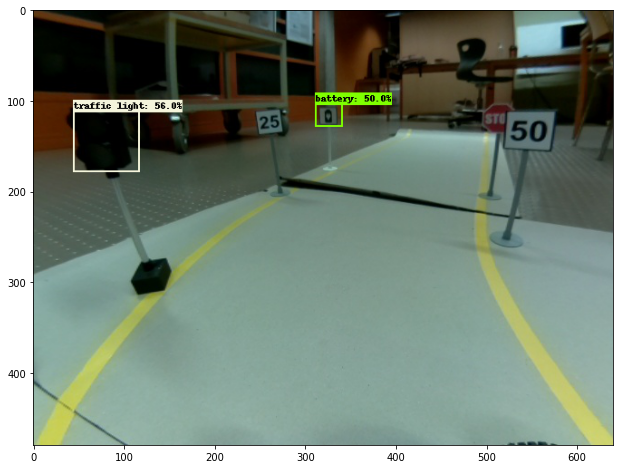

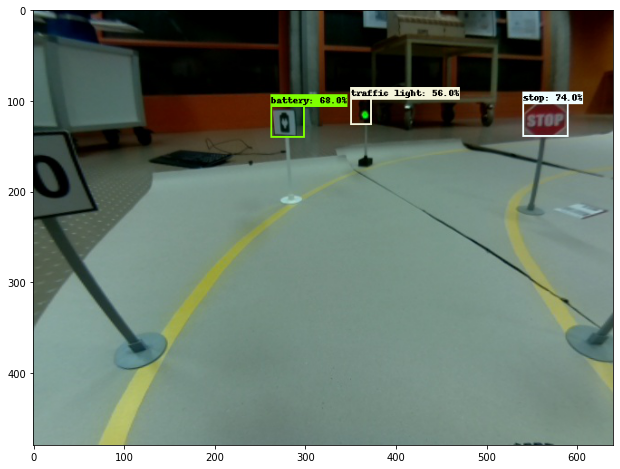

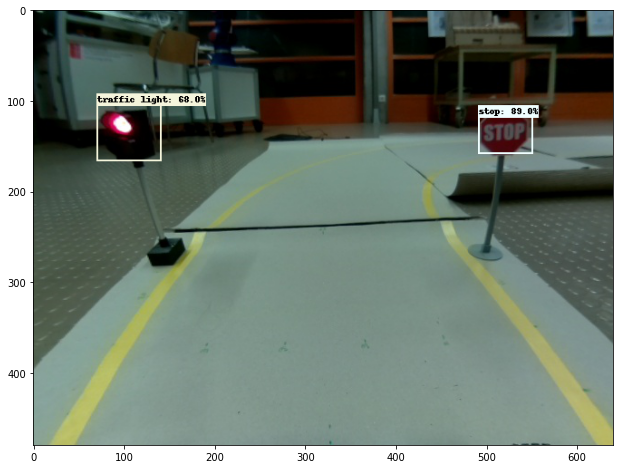

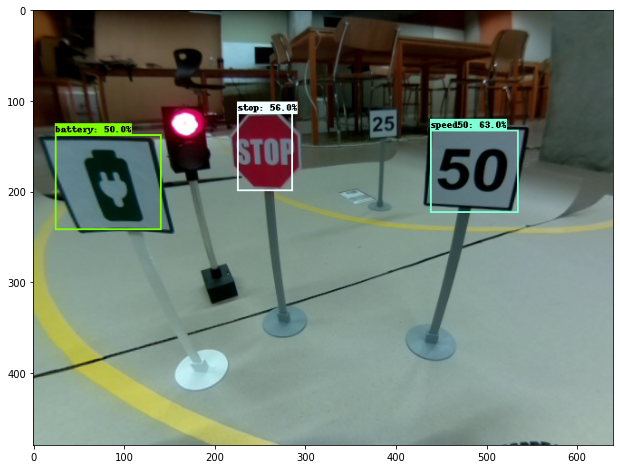

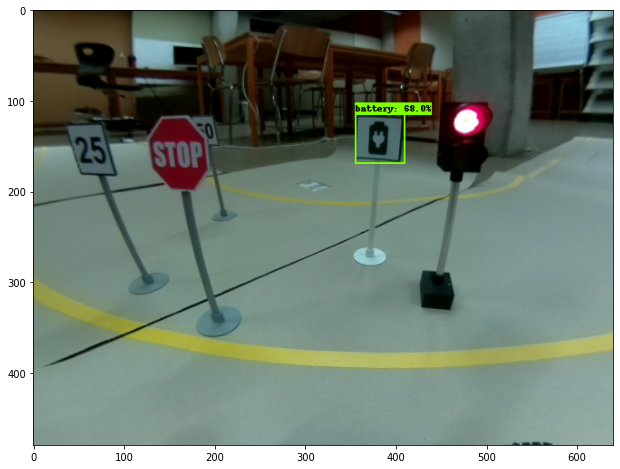

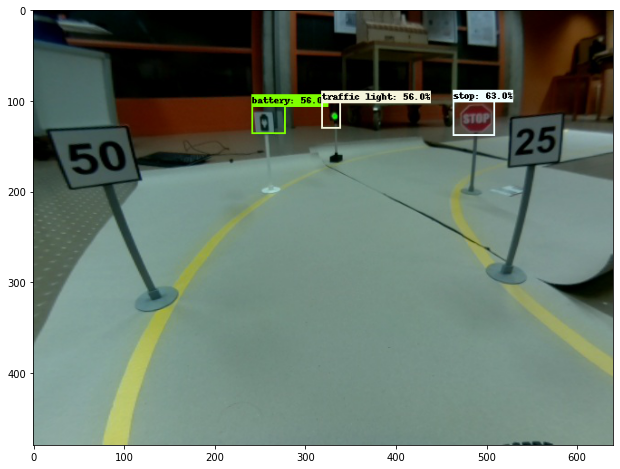

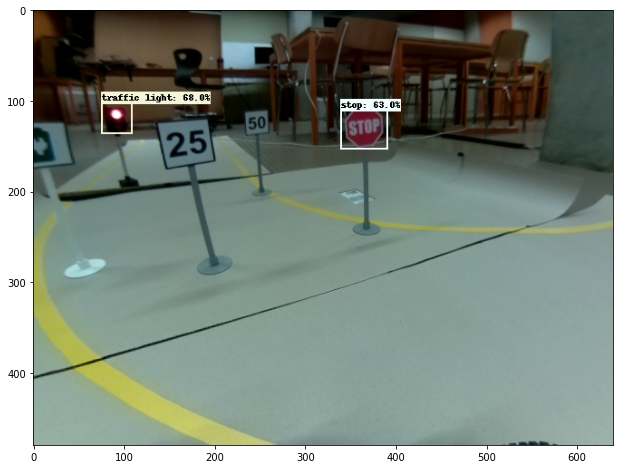

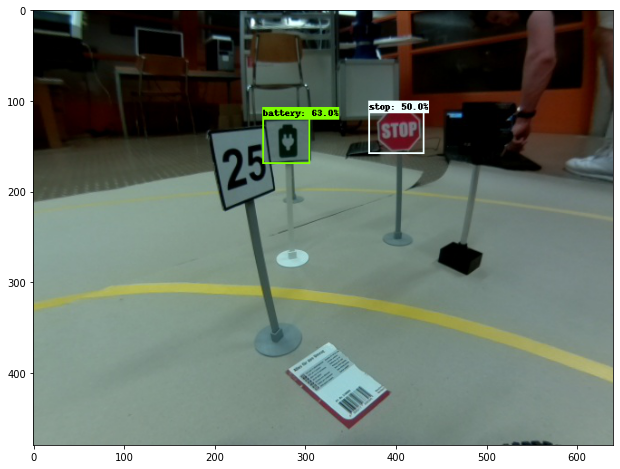

In [37]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Convert to Edge TPU's tflite Format  
The only known way, at time of writing (April 2019), is to download the below quantized tflite file from above, and use [Google's web compiler](https://coral.withgoogle.com/web-compiler/) to convert to Edge TPU's tflite format.   Unfortunately, this step has to be done by hand, and NOT via a script.  

Here are the requirements of Edge TPU web compiler.  If you have followed the above steps closely, you have met these requirements.

- Tensor parameters are quantized (8-bit fixed-point numbers). You must use quantization-aware training (post-training quantization is not supported).   (this is why we are using `ssd_mobilenet_v2_quantized` base model and not the  `ssd_mobilenet_v2` base model   
- Tensor sizes are constant at compile-time (no dynamic sizes).
- Model parameters (such as bias tensors) are constant at compile-time.
- Tensors are either 1-, 2-, or 3-dimensional. If a tensor has more than 3 dimensions, then only the 3 innermost dimensions may have a size greater than 1.
- The model uses only the operations supported by the Edge TPU 

In [38]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/road_signs_quantized.tflite'

ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/road_signs_quantized.tflite': No such file or directory


Wait for about 1-2 minutes for compilation to finish.  And we can download the model file as `road_signs_quantized_edgetpu.tflite`.  This is the file you need to copy to raspberry pi with TPU to run object detection.

We are all done with colab notebook training, now time to switch back to raspberry pi, and run `~/DeepPiCar/models/object_detection/code/object_detection_usb.py`.  You should see a video feed where road sign and persons are boxed with confidence level around them.  

```bash
# make sure the the road_signs_quantized_edgetpu.tflite is in the right directory in your pi
pi@raspberrypi:~/DeepPiCar/models/object_detection/data/model_result $ ls -ltr
total 10040
-rw-r--r-- 1 pi pi      97 Apr 15 01:01 road_sign_labels.txt
-rw-r--r-- 1 pi pi 4793504 Apr 16 15:49 road_signs_quantized.tflite
-rw-r--r-- 1 pi pi 5478080 Apr 16 15:49 road_signs_quantized_edgetpu.tflite

pi@raspberrypi:~/DeepPiCar/models/object_detection $ python3 code/object_detection_usb.py

------
2019-04-16 16:22:28.489224: 13.49 FPS, 74.12ms total, 70.84ms in tf 
Green Traffic Light, 80% [[240.61578751 131.68985367]
 [287.21975327 195.79172134]] 60.42ms
Stop Sign, 44% [[  0.         305.1651001 ]
 [180.84949493 409.32563782]] 60.42ms

------
2019-04-16 16:22:28.618309: 14.83 FPS, 67.44ms total, 60.42ms in tf 
Person, 89% [[505.6583786  279.52325821]
 [530.85933685 360.0169754 ]] 62.54ms
Green Traffic Light, 72% [[237.96649933 130.58757782]
 [283.52127075 203.24180603]] 62.54ms
Red Traffic Light, 62% [[283.23583603 169.27398682]
 [330.91316223 269.20692444]] 62.54ms
Stop Sign, 56% [[ 51.01628304 165.80377579]
 [101.48646355 227.05183029]] 62.54ms
Person, 44% [[396.8661499  298.65327835]
 [468.4034729  422.04421997]] 62.54ms
------

```

# Section 6: Last Words on this Project

Of course, depending many factors, not all objects in the video frame will be identified.  This is the chance to improve your model.   Try to train longer, or train with more labeled images, or augment your existing images with different zooms/rotations/contrast/lighting.  In my case, I started with one camera, which was somewhat fuzzy, and precision low.  When I switched to a HD camera, the model precision was significantly better.   This was just another way.

It is awesome that for just over $100 in hardware, we can do real time object detection at home.   Moreover, thanks to Google, all you need is a browser to train this huge model!  Having fun with your own raspberry pi object detection projects!  